# Вештачке неуронске мреже - оцена објективности текста

## Додатне библиотеке и визуелизација

Библиотеке које су коришћене у оквиру овог пројекта су следеће:

In [51]:
import pandas as pd
import tensorflow as tf
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf


def visualize(hist):
    hist_dict = hist.history
    loss_values = hist_dict['loss']
    val_loss_values = hist_dict['val_loss']
    epoch = range(1, len(hist_dict['accuracy']) + 1)
    plt.plot(epoch, loss_values, 'b', label='Training loss')
    plt.plot(epoch, val_loss_values, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()
    acc_values = hist_dict['accuracy']
    val_acc_values = hist_dict['val_accuracy']
    epoch = range(1, len(acc_values) + 1)
    plt.plot(epoch, acc_values, 'b', label='Training accuracy')
    plt.plot(epoch, val_acc_values, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


def class_report(lnn, test_ds):
    pred_input_func = tf.compat.v1.estimator.inputs.pandas_input_fn(test_ds.drop('Label', axis=1), batch_size=100,
                                                                    num_epochs=1, shuffle=False)
    predict = list(lnn.predict(input_fn=pred_input_func))
    final_pred = []
    for pred in predict:
        final_pred.append(pred['class_ids'][0])

    print(classification_report(test_ds['Label'], final_pred))

## Изглед скупа података

Скуп се састоји од броја одређених параметара самог текста. Скуп података има 59 параметара, на основу којих се даје оцена објективности текста.

In [52]:
data = pd.read_csv('data.csv')
data

,TextID,URL,Label,totalWordsCount,semanticobjscore,semanticsubjscore,CC,CD,DT,EX,...,pronouns2nd,pronouns3rd,compsupadjadv,past,imperative,present3rd,present1st2nd,sentence1st,sentencelast,txtcomplexity
0,Text0001,http://msn.foxsports.com/foxsoccer/mexico/stor...,objective,109,0,1,7,9,0,5,...,0,3,0,11,0,0,0,0,1,18
1,Text0002,http://msn.foxsports.com/foxsoccer/premierleag...,objective,309,21,4,1,19,1,4,...,0,10,0,13,0,14,9,1,1,14
2,Text0003,http://uk.eurosport.yahoo.com/04022011/58/fed-...,objective,149,6,1,8,14,0,5,...,0,2,0,8,0,3,2,1,1,18
3,Text0004,http://uk.eurosport.yahoo.com/07022011/58/bund...,objective,305,18,5,7,26,0,10,...,0,8,3,13,1,7,1,1,1,20
4,Text0005,http://uk.eurosport.yahoo.com/05022011/58/fed-...,objective,491,23,8,33,47,0,12,...,0,16,2,34,1,5,6,1,1,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Text0996,http://www.nba.com/pistons/news/blaha_090313.html,subjective,926,46,34,5,83,1,20,...,16,46,10,13,12,49,29,1,1,24
996,Text0997,http://www.nba.com/pistons/news/smashing_succe...,subjective,876,48,26,9,109,1,16,...,8,43,5,34,9,19,31,1,1,21
997,Text0998,http://www.foxsportswest.com/01/07/13/Hypocrit...,subjective,1469,82,53,14,171,1,10,...,9,49,12,40,19,51,42,1,1,18
998,Text0999,http://www.football365.com/f365-features/84318...,subjective,343,7,5,4,24,0,9,...,0,8,1,3,3,25,7,1,1,11


## Препроцесирање података

У оквиру скупа података откривени су неки параметри који не утичу на сам процес класификације, то су јединствени идентификатор текста, и адреса странице са које је преузет текст као и атрибути који су константе, имају исту вредност за све текстове, па су они уклоњени. Такође, што се тиче лабеле која специфицира класу, извршено је прекодирање (*objective* -> 0, *subjective* -> 1). Уочено је такође да је однос класа 62:38, стога је урађено и балансирање података због бољих резултата класификације.. С обзиром да је потребно поделити податке, у оквиру препроцесирања је извршена и подела података на тренинг, тест и валидациони скуп. Такође је извршено и пребацивање скупа података у оквиру *tensor* објекта, са одабиром дела података који ће се користити при тренирању модела.

In [53]:
def preprocess_label(data):
    list_append = []
    for i in data['Label']:
        if i == 'objective':
            list_append.append(0)
        else:
            list_append.append(1)
    return list_append


def resample_data(data):
    lab1 = len(data[data['Label'] == 1])
    lab0 = len(data[data['Label'] == 0])

    if lab1 > lab0:
        df_majority = data[data['Label'] == 1]
        df_minority = data[data['Label'] == 0]
    else:
        df_majority = data[data['Label'] == 0]
        df_minority = data[data['Label'] == 1]

    df_minority_upsampled = resample(df_minority,
                                     replace=True,
                                     n_samples=df_majority['Label'].count(),
                                     random_state=0)

    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    return df_upsampled


def preprocess_data(data):
    data['Label'] = preprocess_label(data)
    data = data.drop('TextID', axis=1)
    data = data.drop('URL', axis=1)
    data = data.drop('NNP', axis=1)
    data = data.drop('WRB', axis=1)

    data = resample_data(data)
    
    #data = data.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

    return data


def data_to_dataset(data, shuffle=True, batch_size=32):
    dataframe = data.copy()
    labels = dataframe.pop('Label')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds


def split_data(data, batch_size, precode=True):
    train_ds, test_ds = train_test_split(data, test_size=0.2, random_state=0)
    train_ds, val_ds = train_test_split(train_ds, test_size=0.2, random_state=0)

    if precode:
        train_ds = data_to_dataset(train_ds, batch_size=batch_size)
        val_ds = data_to_dataset(val_ds, shuffle=False, batch_size=batch_size)
        test_ds = data_to_dataset(test_ds, shuffle=False, batch_size=batch_size)

    return train_ds, val_ds, test_ds

In [54]:
data = pd.read_csv('data.csv')
data = preprocess_data(data)
data

,Label,totalWordsCount,semanticobjscore,semanticsubjscore,CC,CD,DT,EX,FW,INs,...,pronouns2nd,pronouns3rd,compsupadjadv,past,imperative,present3rd,present1st2nd,sentence1st,sentencelast,txtcomplexity
0,0,109,0,1,7,9,0,5,8,6,...,0,3,0,11,0,0,0,0,1,18
1,0,309,21,4,1,19,1,4,35,23,...,0,10,0,13,0,14,9,1,1,14
2,0,149,6,1,8,14,0,5,15,11,...,0,2,0,8,0,3,2,1,1,18
3,0,305,18,5,7,26,0,10,37,21,...,0,8,3,13,1,7,1,1,1,20
4,0,491,23,8,33,47,0,12,61,36,...,0,16,2,34,1,5,6,1,1,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,1,970,59,24,16,70,0,13,78,81,...,11,17,3,53,16,10,10,1,1,48
821,1,996,55,20,32,93,0,21,99,58,...,0,25,8,31,7,31,32,1,1,16
652,1,1495,71,38,15,130,3,43,143,102,...,6,36,9,38,1,53,33,1,1,39
832,1,970,59,24,16,70,0,13,78,81,...,11,17,3,53,16,10,10,1,1,48


## Одабир модела за класификацију

У разматрање су узета два модела, линеарни класификатор (*LNN*) и *DNN* (*Dense Neural Network*). Након добијених резултата који ће бити приказани, одлучено је да се већа пажња посвети *DNN* моделу. Штп се тиче *DNN* модела, иницијалне оптимизациона функција је Адам, иницијална *loss* функција је *MeanSquaredLogarithmicError*, а *learning_rate* стављено да буде 0.0005.

In [55]:
def create_DNN(list_feat, act):
    feature_layer = tf.keras.layers.DenseFeatures(list_feat)
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation=act)
    ])

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-4),
                  loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                  metrics=['accuracy'])
    return model


def create_LNN(train, train_labels, list_feat):
    input_func = tf.compat.v1.estimator.inputs.pandas_input_fn(x=train, y=train_labels, batch_size=32, num_epochs=100,
                                                               shuffle=True)

    model = tf.estimator.LinearClassifier(feature_columns=list_feat, n_classes=2)
    model.train(input_fn=input_func, steps=1000)

    return model

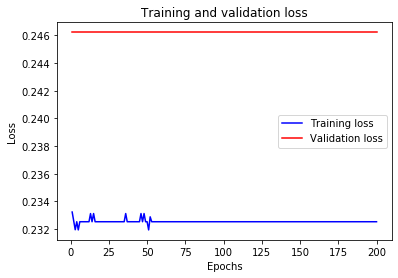

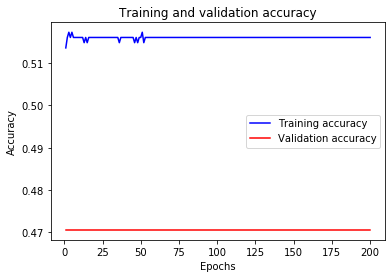

6/6 [==============================] - 0s 6ms/step - loss: 0.2479 - accuracy: 0.4724
Accuracy 0.47244096


In [56]:
data1 = data.drop('Label', axis=1)
list_feat = [tf.feature_column.numeric_column(my_feature) for my_feature in data1.columns]
train_ds, val_ds, test_ds = split_data(data, batch_size=48)
model = create_DNN(list_feat, 'tanh')
hist = model.fit(train_ds, validation_data=val_ds, epochs=200, verbose=0)
visualize(hist)
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

In [57]:
train_ds, val_ds, test_ds = split_data(data, 48, False)
lnn = create_LNN(train_ds.drop('Label', axis=1), train_ds['Label'], list_feat)
class_report(lnn, test_ds)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\PC\\AppData\\Local\\Temp\\tmpcvty1qh8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorf

## Додатно процесирање података - нормализација и одабир најбољих атрибута

Да би се побољшали резултати класификације, урађена је нормализација података, односно свођење вредности свих атрибута на интервал између 0 и 1. Такође је извршен и одабир атрибута који највише утичу на класификацију коришћењем *SelectKBest* методе. У наставку ће бити приказани резултати класификације када су подаци нормализовани, и са различитим бројем атрибута. Што се тиче иницијалног тестирања, узето је да је број атрибута који се издвајају 25 и да је функција активације *tanh*.

In [58]:
def select_attributes(data, k):
    labels = data['Label']
    data = data.drop('Label', axis=1)

    data = data.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

    cols = data.columns

    # feature extraction
    test = SelectKBest(score_func=f_classif, k=k)
    fit = test.fit(data, labels)

    br = fit.get_support(indices=True)
    col = []
    for i in range(len(cols)):
        if i not in br:
            col.append(cols[i])
    data_new = data.drop(columns=col, axis=1)
    data_new = data_new.join(labels)

    return data_new, labels

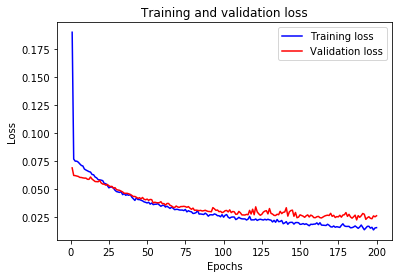

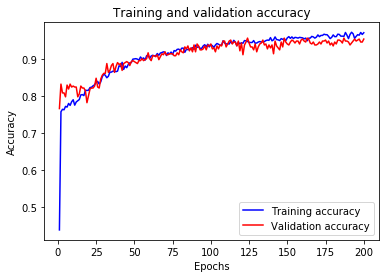

10/10 [==============================] - 0s 4ms/step - loss: 0.0300 - accuracy: 0.9412
Accuracy 0.9411765


In [59]:
data, labels = select_attributes(data, 25)
data1 = data.drop('Label', axis=1)
list_feat = [tf.feature_column.numeric_column(my_feature) for my_feature in data1.columns]
train_ds, val_ds, test_ds = split_data(data, batch_size=48)
model = create_DNN(list_feat, 'tanh')
hist = model.fit(train_ds, validation_data=val_ds, epochs=200, verbose=0)
visualize(hist)
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

## Тестови са различитим бројем атрибута

<table>
    <tr>
        <th>Број атрибута</th>
        <th>Тачност класификације</th>
    </tr>
    <tr>
        <td>59</td>
        <td>89%</td>
    </tr>
     <tr>
        <td>50</td>
        <td>92.64%</td>
    </tr>
     <tr>
        <td>45</td>
        <td>92.85%</td>
    </tr>
     <tr>
        <td>40</td>
        <td>93.48%</td>
    </tr>
     <tr>
        <td>35</td>
        <td>93.69%</td>
    </tr>
     <tr>
        <td>30</td>
        <td>93.48%</td>
    </tr>
     <tr>
        <td>25</td>
        <td>94.11%</td>
    </tr>
     <tr>
        <td>20</td>
        <td>93.48%</td>
    </tr>
</table>

## Тестови са различитим активационим функцијама

На основу претходног теста, утврђено је да је најидеалнији број атрибута 25, стога је овај тест вршен над тим бројем атрибута.

<table>
    <tr>
        <td>Назив активационе функције</td>
        <th>relu</th>
        <th>sigmoid</th>
        <th>tanh</th>
    </tr>
     <tr>
         <td>Тачност класификације</td>
        <td>92.85%</td>
        <td>92.00%</td>
        <td>94.11%</td>
    </tr>
</table>

## Тестови са различитим оптимизационим функцијама и *loss* функцијама

Тестови су рађени над 25 атрибута и најбољом активационом функцијом, у овом случају је то *tanh*.

<table>
    <tr>
        <th>Назив оптимизационе функције</th>
        <th>MeanSquaredLogarithmicError</th>
        <th>BinaryCrossentropy</th>
        <th>Hinge</th>
        <th>MeanSquaredError</th>
    </tr>
    <tr>
        <td>AdaDelta</td>
        <td>64.00%</td>
        <td>52.00%</td>
        <td>41.00%</td>
        <td>59.00%</td>
    </tr>
    <tr>
        <td>Adam</td>
        <td>94.11%</td>
        <td>91.00%</td>
        <td>86.00%</td>
        <td>92.00%</td>
    </tr>
    <tr>
        <td>Nadam</td>
        <td>93.27%</td>
        <td>91.00%</td>
        <td>88.00%</td>
        <td>92.64%</td>
    </tr>
    <tr>
        <td>SGD</td>
        <td>77.30%</td>
        <td>74,70%</td>
        <td>72.50%</td>
        <td>75.00%</td>
    </tr>

</table>

## Утицај *dropout* слоја и функција регуларизације на резултате класификације

In [60]:
def create_DNN_without_dropout(list_feat, act):
    feature_layer = tf.keras.layers.DenseFeatures(list_feat)
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation=act)
    ])

    model.compile(optimizer=tf.optimizers.SGD(learning_rate=5e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=['accuracy'])
    return model

def create_DNN_with_regularizers(list_feat, act):
    feature_layer = tf.keras.layers.DenseFeatures(list_feat)
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1()),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l1()),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation=act)
    ])

    model.compile(optimizer=tf.optimizers.SGD(learning_rate=5e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=['accuracy'])
    return model

def visualize_loss(hist, hist_without, hist_with):
    hist_dict = hist.history
    loss_values = hist_dict['loss']
    val_loss_values = hist_dict['val_loss']
    
    hist_dict1 = hist_without.history
    loss_values1 = hist_dict1['loss']
    val_loss_values1 = hist_dict1['val_loss']
    
    hist_dict2 = hist_with.history
    loss_values2 = hist_dict2['loss']
    val_loss_values2 = hist_dict2['val_loss']
    
    epoch = range(1, len(hist_dict['accuracy']) + 1)
    plt.plot(epoch, loss_values, 'b', label='Training loss normal')
    plt.plot(epoch, val_loss_values, 'r', label='Validation loss normal')
    
    plt.plot(epoch, loss_values1, 'g', label='Training loss without dropout')
    plt.plot(epoch, val_loss_values1, 'c', label='Validation loss without dropout')
    
    plt.plot(epoch, loss_values2, 'y', label='Training loss with regularizers')
    plt.plot(epoch, val_loss_values2, 'k', label='Validation loss with regularizers')
    
    
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [66]:
data = pd.read_csv('data.csv')

data = preprocess_data(data)
data, labels = select_attributes(data, 25)
data1 = data.drop('Label', axis=1)
list_feat = [tf.feature_column.numeric_column(my_feature) for my_feature in data1.columns]
train_ds, val_ds, test_ds = split_data(data, batch_size=48)
model = create_DNN_without_dropout(list_feat, 'tanh')
hist_without_dropout = model.fit(train_ds, validation_data=val_ds, epochs=200, verbose=0)


In [67]:
data = pd.read_csv('data.csv')

data = preprocess_data(data)
data, labels = select_attributes(data, 25)
data1 = data.drop('Label', axis=1)
list_feat = [tf.feature_column.numeric_column(my_feature) for my_feature in data1.columns]
train_ds, val_ds, test_ds = split_data(data, batch_size=48)
model = create_DNN_with_regularizers(list_feat, 'tanh')
hist_with_regularizers = model.fit(train_ds, validation_data=val_ds, epochs=200, verbose=0)

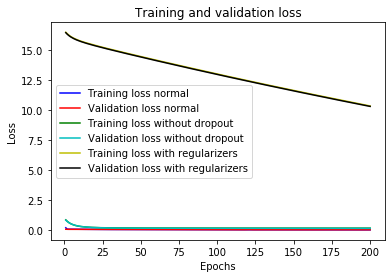

In [68]:
visualize_loss(hist,hist_without_dropout,hist_with_regularizers)